In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ugradio
%matplotlib inline

## Calibration ##

### Getting $s_{offline}$ ###

In [59]:
## Getting the spectrum using numpy functions ##

# For the offline spectrum, we have 16000 Blocks
# These blocks are divided into 320 'towers'
# (Thanks to Sharks in Space for the terminology)
# Each tower contains 50 blocks

# First, define useful parameters

ntowers = 20           # use only a subset of towers
nblocks = 50           # blocks per tower
nsamples = 16000
vsamp = 62.5/2         # sampling freq, in MHz
freqs = np.linspace(-vsamp/2, vsamp/2, nsamples)

# Next, initialize an array of zeros of the correct shape

voltages = np.zeros(ntowers*nblocks*nsamples, dtype='complex128').reshape(nblocks*ntowers,nsamples)

# Then cycle through all of the data and input it into the voltages array
# In the interest of time/memory, the voltage data is in frequency space

for i in range(ntowers):
    data = np.load('Calibration Data/ColdSkyBlock{:d}.npy'.format(i+1))
    for j in range(nblocks):
        voltages[nblocks*i + j] = np.fft.fftshift(np.fft.fft(data[j+1]))  # data[0] contains parameters

In [2]:
## Getting the spectrum without using np.mean or np.median ##

# Same comments as above

ntowers = 320          # use all towers
nblocks = 50
nsamples = 16000
vsamp = 62.5/2
freqs = np.linspace(-vsamp/2, vsamp/2, nsamples)

# Initialize average array
s_offline = np.zeros(nsamples)

# Loop through all sets of data
for i in range(ntowers):
    data = np.load('Calibration Data/ColdSkyBlock{:d}.npy'.format(i+1))
    # Loop through all blocks in tower
    for j in range(nblocks):
        voltages = np.fft.fftshift(np.fft.fft(data[j+1]))
        power = np.abs(voltages)**2
        s_offline += power
        
# Divide out by number of blocks
s_offline /= (ntowers*nblocks)

In [3]:
# Remove DC component
key = np.where(s_offline==s_offline.max())
s_offline[key] = np.mean(s_offline[nsamples/2-300:nsamples/2+300])

In [60]:
## Take a look at different types of smoothing ##

# Smooth using np.mean()
mean_power = np.mean(np.abs(voltages)**2, axis=0)

# Smooth using np.median()
median_power = np.median(np.abs(voltages)**2, axis=0)

In [61]:
# Remove the DC component
key1 = np.where(mean_power==mean_power.max())
key2 = np.where(median_power==median_power.max())

mean_power[key1] = np.mean(mean_power[nsamples/2-300:nsamples/2+300])
median_power[key2] = np.mean(median_power[nsamples/2-300:nsamples/2+300])

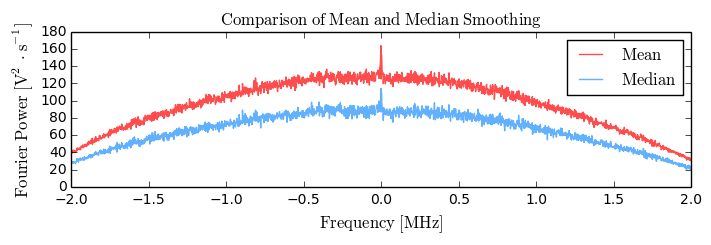

In [103]:
# Plot the results
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$\mathrm{Frequency\ [MHz]}$', fontsize=12)
ax.set_ylabel(r'$\mathrm{Fourier\ Power\ [V^2\cdot\ s^{-1}]}$', fontsize=12)
ax.set_title(r'$\mathrm{Comparison\ of\ Mean\ and\ Median\ Smoothing}$', fontsize=12)

ax.set_xlim(-2,2)

ax.plot(freqs, mean_power[::-1], color='red', alpha=0.7, label=r'$\mathrm{Mean}$')
ax.plot(freqs, median_power[::-1], color='dodgerblue', alpha=0.7, label=r'$\mathrm{Median}$')
ax.legend()

#plt.tight_layout()
fig.savefig('Plots/s_offline_one_channel_big.pdf')
plt.show()

In [58]:
## Now let's see what happens when we average over channels ##

# We need each channel to have a bandwidth of at least 1kHz
# Just to get an idea, let's use 100 channels
# Timed out with the original dataset, so reduced to 1000 blocks

nchannels = 1000

voltages_j = voltages.copy().reshape(ntowers*nblocks,nsamples/nchannels,nchannels)
power_j = np.abs(voltages_j)**2
# Take the mean, then reshape back to 1D
mean_by_channels = np.mean(power_j, axis=0).reshape(nsamples)

# Take the median, same deal
median_by_channels = np.median(power_j, axis=0).reshape(nsamples)

In [59]:
# Remove the DC component
key1 = np.where(mean_by_channels==mean_by_channels.max())
key2 = np.where(median_by_channels==median_by_channels.max())

mean_by_channels[key1] = np.mean(mean_by_channels[nsamples/2-300:nsamples/2+300])
median_by_channels[key2] = np.mean(median_by_channels[nsamples/2-300:nsamples/2+300])

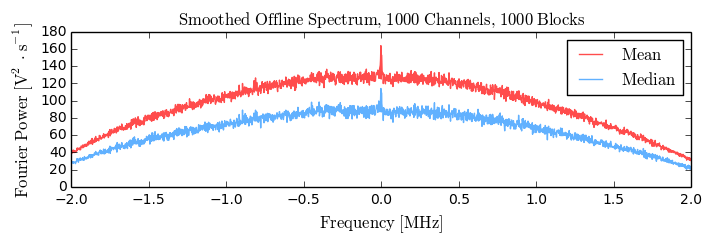

In [60]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$\mathrm{Frequency\ [MHz]}$', fontsize=12)
ax.set_ylabel(r'$\mathrm{Fourier\ Power\ [V^2\cdot\ s^{-1}]}$', fontsize=12)
ax.set_title(r'$\mathrm{Smoothed\ Offline\ Spectrum,\ 1000\ Channels,\ 1000\ Blocks}$', fontsize=12)

ax.set_xlim(-2,2)

ax.plot(freqs, mean_by_channels[::-1], color='red', alpha=0.7, label=r'$\mathrm{Mean}$')
ax.plot(freqs, median_by_channels[::-1], color='dodgerblue', alpha=0.7, label=r'$\mathrm{Median}$')
ax.legend()

fig.savefig('Plots/s_offline_1000_channels.pdf')
plt.show()

In [60]:
s_offline = mean_power

## Getting $s_{online}$ ##

In [4]:
# Note that the method of averaging that I will use
# from here on out produces the mean of the data, but
# requires much less memory than using the np methods

# Initialize array of zeros

s_online = np.zeros(nsamples)

# Cycle through all blocks of data
# As far as I can tell, this actually takes less time to
# complete than the method used above

for i in range(ntowers):
    data = np.load('Part 2/Block{:d}.npy'.format(i+1))
    for j in range(nblocks):
        # Load in voltages in frequency space
        voltages = np.fft.fftshift(np.fft.fft(data[j+1]))
        # Transform into a power
        power = np.abs(voltages)**2
        # Add to online spectrum
        s_online += power
        
# Divide out number of blocks averaged over
s_online /= (nblocks*ntowers)

In [5]:
# Remove the DC component
key = np.where(s_online==s_online.max())

s_online[key] = np.mean(s_online[nsamples/2-300:nsamples/2+300])

In [11]:
# Only want to use data for values within lowpass filter for shape

freqs_key = np.where(np.abs(freqs) <= 2)
reduced_freqs = freqs[freqs_key]
shape = s_online[freqs_key]/s_offline[freqs_key]

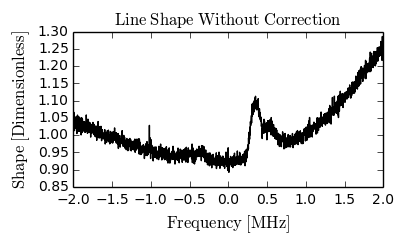

In [69]:
fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$\mathrm{Frequency\ [MHz]}$', fontsize=12)
ax.set_ylabel(r'$\mathrm{Shape\ [Dimensionless]}$', fontsize=12)
ax.set_title(r'$\mathrm{Line\ Shape\ Without\ Correction}$', fontsize=12)

ax.plot(reduced_freqs, shape[::-1], color='k')

#fig.savefig('Plots/Uncorrected_Shape.pdf')
plt.show()

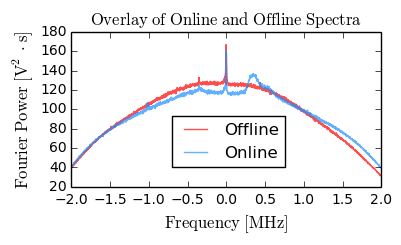

In [78]:
fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$\mathrm{Frequency\ [MHz]}$', fontsize=12)
ax.set_ylabel(r'$\mathrm{Fourier\ Power\ [V^2\cdot\ s]}$', fontsize=12)
ax.set_title(r'$\mathrm{Overlay\ of\ Online\ and\ Offline\ Spectra}$', fontsize=12)

ax.plot(reduced_freqs, s_offline[freqs_key][::-1], color='red', alpha=0.7, label='Offline')
ax.plot(reduced_freqs, s_online[freqs_key][::-1], color='dodgerblue', alpha=0.7, label='Online')

ax.legend(loc=(0.325,0.125))

#plt.tight_layout()
fig.savefig('Plots/Online_vs_Offline.pdf')
plt.show()

## Get $T_{sys}$ ##

In [8]:
# Define calibration temperature
Tcal = 300 #K

# Get s_300K
ntowers_300K = 20
s_300K = np.zeros(nsamples)

for i in range(ntowers_300K):
    data = np.load('Calibration Data/300KBlock{:d}.npy'.format(i+1))
    for j in range(nblocks):
        voltages = np.fft.fftshift(np.fft.fft(data[j+1]))
        power = np.abs(voltages)**2
        s_300K += power
        
s_300K /= (ntowers_300K*nblocks)

In [9]:
# Compute sums over entire bandwidth
sum1 = np.sum(s_offline.copy())
sum2 = np.sum(s_300K.copy()-s_offline.copy())

# Compute system temperature
Tsys = sum1*Tcal/sum2

# Compute calibrated system (frequency axis is reversed)
calibrated_spectrum = shape[::-1]*Tsys

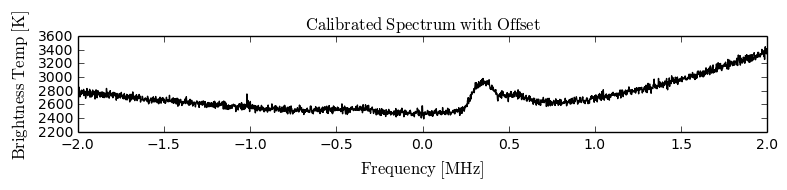

In [54]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$\mathrm{Frequency\ [MHz]}$', fontsize=12)
ax.set_ylabel(r'$\mathrm{Brightness\ Temp\ [K]}$', fontsize=12)
ax.set_title(r'$\mathrm{Calibrated\ Spectrum\ with\ Offset}$', fontsize=12)

ax.plot(reduced_freqs, calibrated_spectrum, color='k')

plt.tight_layout()
fig.savefig('Plots/Calibrated_Spectrum.pdf')
plt.show()

In [46]:
# Now plot relative to Doppler velocity
fo = 1420.4058 #MHz
c = 3e5 #km/s
velocities = -(reduced_freqs+1420-fo)*c/fo

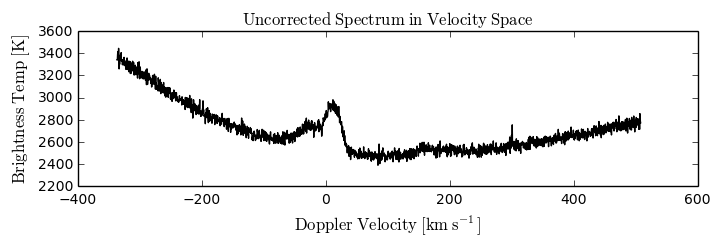

In [101]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$\mathrm{Doppler\ Velocity\ [km\ s^{-1}]}$', fontsize=12)
ax.set_ylabel(r'$\mathrm{Brightness\ Temp\ [K]}$', fontsize=12)
ax.set_title(r'$\mathrm{Uncorrected\ Spectrum\ in\ Velocity\ Space}$', fontsize=12)

ax.plot(velocities, calibrated_spectrum, color='k')

#plt.tight_layout()
#fig.savefig('Plots/Doppler_Shift_Uncorrected.pdf')
plt.show()

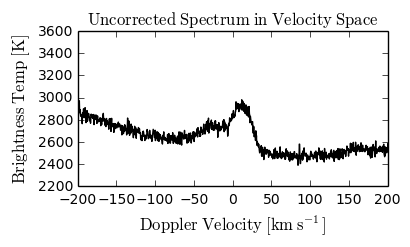

In [84]:
fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$\mathrm{Doppler\ Velocity\ [km\ s^{-1}]}$', fontsize=12)
ax.set_ylabel(r'$\mathrm{Brightness\ Temp\ [K]}$', fontsize=12)
ax.set_title(r'$\mathrm{Uncorrected\ Spectrum\ in\ Velocity\ Space}$', fontsize=12)

ax.set_xlim(-200,200)

ax.plot(velocities, calibrated_spectrum, color='k')

#plt.tight_layout()
fig.savefig('Plots/Doppler_Shift_Uncorrected_Zoom.pdf')
plt.show()

## Rotation Matrices ##

In [19]:
def ang_to_rect(lon=0.0, lat=0.0, deg=False):
    """
    This function produces converts angular coordinates to rectangular
    coordinates.
    
    lon is the azimuthal angle of the angular coordinates. It is
    defaulted to 0.
    
    lat is the latitude of the angular coordinates. It is defaulted to 0.
    
    deg allows for entering (lon,lat) values in either degrees or radians.
    It is assumed that the angles are entered in radians.
    
    This function returns the rectangular representation of the angular
    coordinates (lon,lat) as a numpy array.
    """
    
    if deg:
        lat = np.radians(lat)
        lon = np.radians(lon)
        
    return np.array( [ np.cos(lat)*np.cos(lon), np.cos(lat)*np.sin(lon), np.sin(lat) ] )

def rect_to_ang(x, deg=False):
    """
    This function converts from rectangular coordinates to angular coordinates.
    
    x is the rectangular representation of the angular coordinates.
    
    deg allows for the angles to be returned in either degrees or radians.
    Angles are returned in radians by default, as a numpy array.
    """

    lat = np.arcsin(x[2])
    lon = np.arctan2(x[1], x[0])
    
    if lon < 0:
        lon += 2*np.pi
    
    if deg:
        lat = np.degrees(lat)
        lon = np.degrees(lon)
        
    return np.array( [lon, lat] )

In [20]:
def dd(deg=0.0, m=0.0, s=0.0, sexagesimal=False):
    """
    This function converts deg-min-sec representations to decimal degrees.
    
    deg is the degree component.
    
    m is the arcminute component.
    
    s is the arcsecond component.
    
    sexagesimal allows for sexagesimal representations to be converted to
    decimal degree representations.
    
    This function returns the decimal degree representation of the degree,
    minute, second representation.
    """
    
    dd = deg + m/60. + s/3600.
    
    if sexagesimal:
        dd *= 15
        
    return dd

In [16]:
def RA_to_HA(x, LST = ugradio.timing.lst(ugradio.timing.julian_date()), invert=False):
    """
    This function allows for the conversion between (ra,dec) and (ha,dec).
    
    x is the vector representation of the celestial coordinates in a
    rectangular frame.
    
    LST is the local sidereal time, with the default setting being the time
    the function is called.
    
    invert is a keyword argument used to determine whether the transformation
    is from (ra,dec) to (ha,dec) or vice-versa. The default is (ra,dec)->(ha,dec).
    
    The function returns the appropriately transformed vector.
    """
    
    # define rotation matrix
    
    R = np.array( [  np.cos(LST), np.sin(LST), 0,
                     np.sin(LST),-np.cos(LST), 0,
                          0     ,      0     , 1 ] ).reshape(3,3)
    
    # add option for inverting transformation
    
    if invert:
        R = R.transpose()
    
    return np.dot(R, x.copy())

In [17]:
def HA_to_AzAlt(x, lat=ugradio.nch.lat, invert=False, deg=True):
    """
    This function allows for transformations between (ha,dec) and (az,alt).
    
    x is the vector representation of the celestial coordinates.
    
    lat is the latitude of the observatory, with the default set to NCH.
    
    invert determines whether the transformation is from (ha,dec) to
    (az,alt) or vice-versa. The default assumption is (ha,dec)->(az,alt).
    
    deg allows for input of lat in degrees or radians. The default
    assumption is that lat is measured in degrees.
    
    This function returns the appropriately transformed vector.
    """
    
    if deg:
        phi = np.radians(lat)
    else:
        phi = lat
    
    # define rotation matrix
    
    R = np.array( [ -np.sin(phi),  0, np.cos(phi),
                         0      , -1,     0      ,
                     np.cos(phi),  0, np.sin(phi) ] ).reshape(3,3)
    
    # add option for inverting transformation
    
    if invert:
        R = R.transpose()
        
    return np.dot(R, x.copy())

In [18]:
def eq_to_gal(x, invert=False, old=False):
    """
    This function allows for the transformation between equatorial
    and galactic coordinates. Note that equatorial coordinates
    correspond to (ra,dec).
    
    x is the vector representation of the celestial coordinates.
    
    invert determines whether the transformation is from equatorial
    to galactic or vice-versa. The default assumption is that x is
    intended to be transformed from equatorial to galactic coordinates.
    
    old allows for the use of the epoch 1950 transformation.
    
    This function returns the appropriately transformed vector.
    """
    
    R = np.array( [ -0.054876, -0.873437, -0.483835,
                     0.494109, -0.444830,  0.746982,
                    -0.867666, -0.198076,  0.455984] ).reshape(3,3)
        
    # add option for using 1950 version of transformation
    
    if old:
        R = np.array( [ -0.066989, -0.872756, -0.483539,
                         0.492728, -0.450347,  0.744585,
                        -0.867601, -0.188375,  0.460200] ).reshape(3,3)
        
    # add option for inverting transformation
    
    if invert:
        R = R.transpose()
        
    return np.dot(R, x.copy())

In [24]:
# This is all for the observation at (l,b) = (120deg,0)
# So we need to use rotation matrices to figure out (ra,dec)
# Luckily, I remembered to store information about where the horn was pointed...
# Unfortunately, I forgot to update it for the retake of the data
# Fortunately, I have the JD saved, so I can still recover (ra,dec), with some work

# Take the JD of a block in the middle
JD = np.real(np.load('Part 2/Block150.npy')[0,0])

# Get the LST corresponding to that JD
LST = ugradio.timing.lst(JD)

# Get the rectangular representation of the galactic coordinates
r = ang_to_rect(lon=120, lat=0, deg=True)

# Transform to RA/Dec
R = eq_to_gal(r, invert=True)

# Transform back to angular coordinates
angles = rect_to_ang(R, deg=True)

# Get the projected velocity
v_proj = ugradio.doppler.get_projected_velocity(angles[0], angles[1], JD)

In [79]:
corrected_velocities = velocities - v_proj/1e3

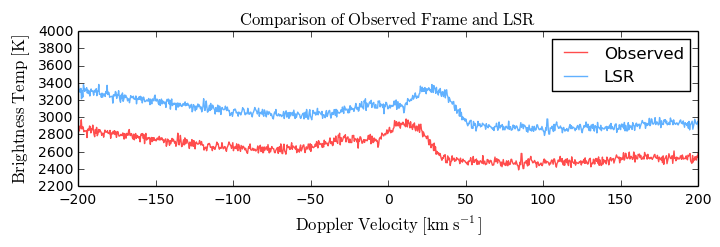

In [104]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel(r'$\mathrm{Doppler\ Velocity\ [km\ s^{-1}]}$', fontsize=12)
ax.set_ylabel(r'$\mathrm{Brightness\ Temp\ [K]}$', fontsize=12)
ax.set_title(r'$\mathrm{Comparison\ of\ Observed\ Frame\ and\ LSR}$', fontsize=12)

ax.set_xlim(-200,200)

ax.plot(velocities, calibrated_spectrum, color='red', alpha=0.7, label='Observed')
ax.plot(corrected_velocities, 400+calibrated_spectrum, color='dodgerblue', alpha=0.7, label='LSR')

ax.legend()

#plt.tight_layout()
fig.savefig('Plots/Observed_vs_LSR.pdf')
plt.show()

In [42]:
# Correct the spectrum by making a polyfit and subtracting it out

# For simplicity, generate a reduced frequency array which only contains values
# on the interval [-2,2]MHz

# Generate the key
freqs_key = np.where(np.abs(freqs) <= 2)

# Get the reduced array
reduced_freqs = freqs[freqs_key]

# Generate a key for the fit
fit_key = np.where(np.abs(reduced_freqs-0.45) >= 0.25)

# Get a 4-th degree fit
p = np.polyfit(reduced_freqs[fit_key],calibrated_spectrum[fit_key], deg=4)

# Generate the fit
fit = p[0]*reduced_freqs**4 + p[1]*reduced_freqs**3 + p[2]*reduced_freqs**2 + p[3]*reduced_freqs + p[4]

# Get the corrected spectrum from the calibrated spectrum and the fit
corrected_spectrum = calibrated_spectrum - fit

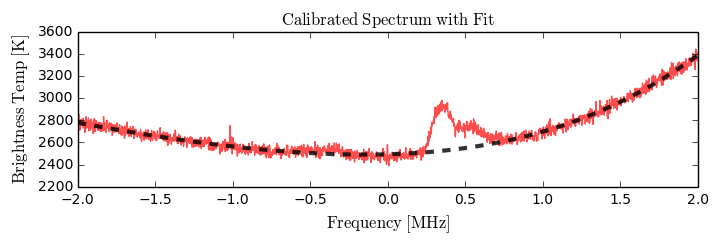

In [105]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$\mathrm{Frequency\ [MHz]}$', fontsize=12)
ax.set_ylabel(r'$\mathrm{Brightness\ Temp\ [K]}$', fontsize=12)
ax.set_title(r'$\mathrm{Calibrated\ Spectrum\ with\ Fit}$', fontsize=12)

ax.plot(reduced_freqs, calibrated_spectrum, color='red', alpha=0.7)
ax.plot(reduced_freqs, fit, color='k', alpha=0.8, ls='--', lw=3)

#plt.tight_layout()
fig.savefig('Plots/Calibrated_Spectrum_with_Fit.pdf')
plt.show()

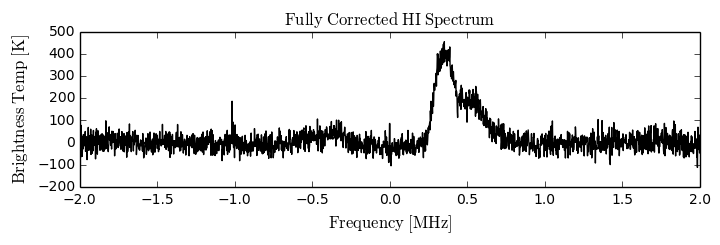

In [110]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$\mathrm{Frequency\ [MHz]}$', fontsize=12)
ax.set_ylabel(r'$\mathrm{Brightness\ Temp\ [K]}$', fontsize=12)
ax.set_title(r'$\mathrm{Fully\ Corrected\ HI\ Spectrum}$', fontsize=12)

ax.plot(reduced_freqs, corrected_spectrum, color='k')

#plt.tight_layout()
fig.savefig('Plots/Complete_Spectrum_version2.pdf')
plt.show()

In [125]:
gaussfit = ugradio.gauss.gaussfit(reduced_freqs, corrected_spectrum, 
                                  amp=[100, 450, 200], 
                                  avg=[-0.4,0.35,0.5], 
                                  sig=[1, 0.25, 0.5])

In [126]:
gaussfit

{'amp': array([ -24.07388132,  376.56358043,  187.17168505]),
 'avg': array([ 0.08744513,  0.34186278,  0.51317475]),
 'sig': array([ 0.14759016,  0.05317512,  0.09990975])}

In [127]:
amp = [ -24.07388132, 376.56358043, 187.1768505]
avg = [ 0.08744513, 0.34186278, 0.51317475]
sig = [ 0.14759016, 0.05317512, 0.09990975]
corrected_fit = ugradio.gauss.gaussval(reduced_freqs, amp, avg, sig)

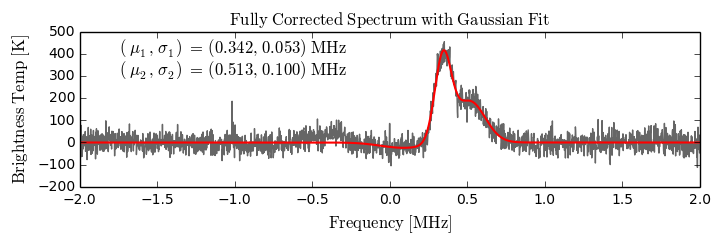

In [137]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel(r'$\mathrm{Frequency\ [MHz]}$', fontsize=12)
ax.set_ylabel(r'$\mathrm{Brightness\ Temp\ [K]}$', fontsize=12)
ax.set_title(r'$\mathrm{Fully\ Corrected\ Spectrum\ with\ Gaussian\ Fit}$', fontsize=12)

ax.plot(reduced_freqs, corrected_spectrum, color='k', alpha=0.6)
ax.plot(reduced_freqs, corrected_fit, color='red', lw=1.5, alpha=1)

ax.text(-1.75,400, r'$(\ \mu_1,\ \sigma_1)\ =\ (0.342,\ 0.053)\ \mathrm{MHz}$', fontsize=12)
ax.text(-1.75,300, r'$(\ \mu_2,\ \sigma_2)\ =\ (0.513,\ 0.100)\ \mathrm{MHz}$', fontsize=12)

#plt.tight_layout()
fig.savefig('Plots/Correct_Spectrum_with_Fit.pdf')
plt.show()

In [118]:
gaussfit

{'amp': array([ -24.07086429,  376.56742896,  187.17243503]),
 'avg': array([ 0.0874467 ,  0.34186249,  0.51317433]),
 'sig': array([ 0.1476424 ,  0.05317555,  0.09990994])}

In [115]:
ugradio.gauss.gaussval?

In [ ]:
    """    
    This function was written with the assumption that it is to be used
    as a rotation matrix--the vector representation of the celestial coordinates
    must be computed outside of this function.
    """

In [41]:
velocities

array([ 1777931.28457912,  1776487.28723219,  1775043.28988526, ...,
       -1175043.28988526, -1176487.28723219, -1177931.28457911])

In [44]:
reduced_freqs[np.where(corrected_spectrum==corrected_spectrum.max())]

array([ 0.35060785])

In [45]:
-(0.3506-fo)*c/fo

40808.279940857545